In [1]:
# GLM Binomial negativa

import os
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import box
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial
import libpysal.weights
from esda.moran import Moran, Moran_Local

ruta_geoformas = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Inventario_geoformas_karsticas_Dunita.shp"
ruta_contorno  = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Contorno_Dunita.shp"
ruta_dem       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\dem_clip.tif"
ruta_slope     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\pendiente.tif"
ruta_twi       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\TWI.tif"
ruta_cover     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Cobertura_final.shp"
ruta_drain     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Drenajes_clip_POT_final.shp"
ruta_fault     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Fallas_lineam.shp"
output_dir     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG"
os.makedirs(output_dir, exist_ok=True)

gdf_points  = gpd.read_file(ruta_geoformas)
gdf_contour = gpd.read_file(ruta_contorno)

# Cuadrícula y conteo
cell_size = 100
minx, miny, maxx, maxy = gdf_contour.total_bounds
xs = np.arange(minx, maxx, cell_size)
ys = np.arange(miny, maxy, cell_size)
polygons = [box(x, y, x+cell_size, y+cell_size) for x in xs for y in ys]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_contour.crs)
grid = gpd.clip(grid, gdf_contour)

join = gpd.sjoin(grid, gdf_points, how='left', predicate='intersects')
counts = join.groupby(join.index).size()
grid['count'] = counts.reindex(grid.index).fillna(0).astype(int)


# Extraer covariables zonales 
grid['dem_mean']   = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_dem,   stats=['mean'], nodata=-9999)]
grid['slope_mean'] = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_slope, stats=['mean'], nodata=-9999)]
grid['twi_mean']   = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_twi,   stats=['mean'], nodata=-9999)]


# Coberturas y distancias 
cov_gdf  = gpd.read_file(ruta_cover)[['d_N3_COBER','geometry']].to_crs(grid.crs)
centroids= grid.copy(); centroids['geometry'] = centroids.centroid
cov_join = gpd.sjoin(centroids, cov_gdf, how='left', predicate='within')
grid['cover'] = cov_join['d_N3_COBER'].fillna('None')

drains = gpd.read_file(ruta_drain).to_crs(grid.crs)
faults = gpd.read_file(ruta_fault).to_crs(grid.crs)
union_drains = drains.geometry.unary_union
union_faults = faults.geometry.unary_union
grid['dist_drain'] = centroids.geometry.distance(union_drains)
grid['dist_fault'] = centroids.geometry.distance(union_faults)


# Preparar el dataframe para el modelado
df = grid[['count','dem_mean','slope_mean','twi_mean','dist_drain','dist_fault','cover']].copy()
df = df.dropna()
y = df['count'].astype(int)
X_vars = df.drop(columns=['count'])
X_vars = pd.get_dummies(X_vars, columns=['cover'], prefix='cov', drop_first=True)
X = sm.add_constant(X_vars.astype(float))
y = y[X.index]

model = sm.GLM(y, X, family=NegativeBinomial())
results = model.fit()
print("Resumen del Modelo GLM Binomial Negativo:")
print(results.summary())

grid_model = grid.loc[X.index].copy()

# Añadimos los residuos del modelo como una nueva columna
grid_model['resid_dev'] = results.resid_deviance

C:\Users\esteb\AppData\Local\Temp\ipykernel_27036\1282686402.py:57: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_drains = drains.geometry.unary_union
C:\Users\esteb\AppData\Local\Temp\ipykernel_27036\1282686402.py:58: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_faults = faults.geometry.unary_union
C:\Users\esteb\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Resumen del Modelo GLM Binomial Negativo:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 2426
Model:                            GLM   Df Residuals:                     2400
Model Family:        NegativeBinomial   Df Model:                           25
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3929.7
Date:                Thu, 26 Jun 2025   Deviance:                       485.48
Time:                        22:17:01   Pearson chi2:                 1.04e+03
No. Iterations:                     8   Pseudo R-squ. (CS):            0.08029
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

C:\Users\esteb\AppData\Local\Temp\ipykernel_27036\658090201.py:8: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(grid_model)


  - Índice de Moran (I): 0.2978
  - P-valor   (p_sim): 0.0010
  - Z-score   (z_sim): 28.2909


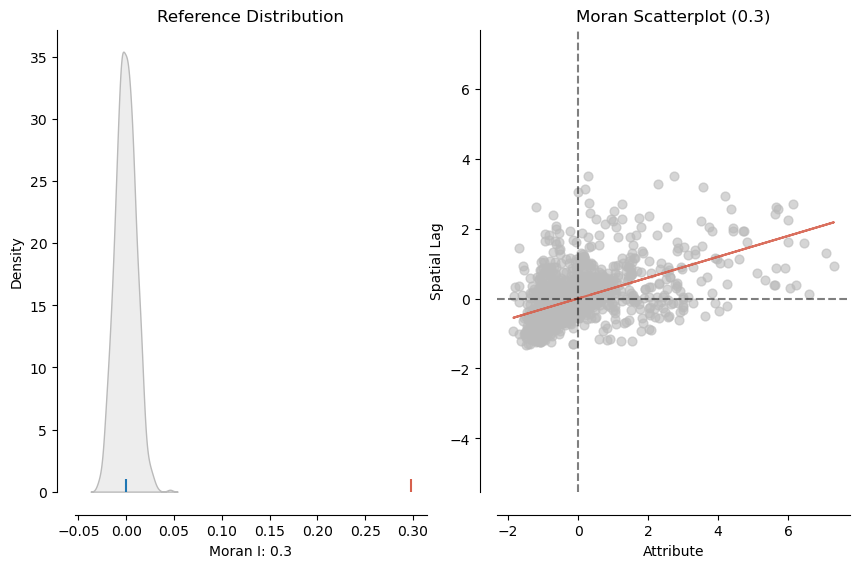

In [5]:
#Autocorrelación espacial global: Indice de Moran

import os
import matplotlib.pyplot as plt
import libpysal
from esda.moran import Moran
from splot.esda import plot_moran  

# Crear matriz de pesos
w = libpysal.weights.Queen.from_dataframe(grid_model)
w.transform = 'r' # Estandarizar por filas

# Calcular Moran Global
moran_global = Moran(grid_model['resid_dev'].values, w)
print(f"  - Índice de Moran (I): {moran_global.I:.4f}")
print(f"  - P-valor   (p_sim): {moran_global.p_sim:.4f}")
print(f"  - Z-score   (z_sim): {moran_global.z_sim:.4f}")

# 3) Gráfico combinado
fig, ax = plot_moran(
    moran_global,
    zstandard=True,
    aspect_equal=True,
    figsize=(10, 6)
)

os.makedirs(output_dir, exist_ok=True)
out_path = os.path.join(output_dir, 'grafico_diagnostico_moran.png')
fig.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()


C:\Users\esteb\AppData\Local\Temp\ipykernel_27036\2436473857.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(grid_model)


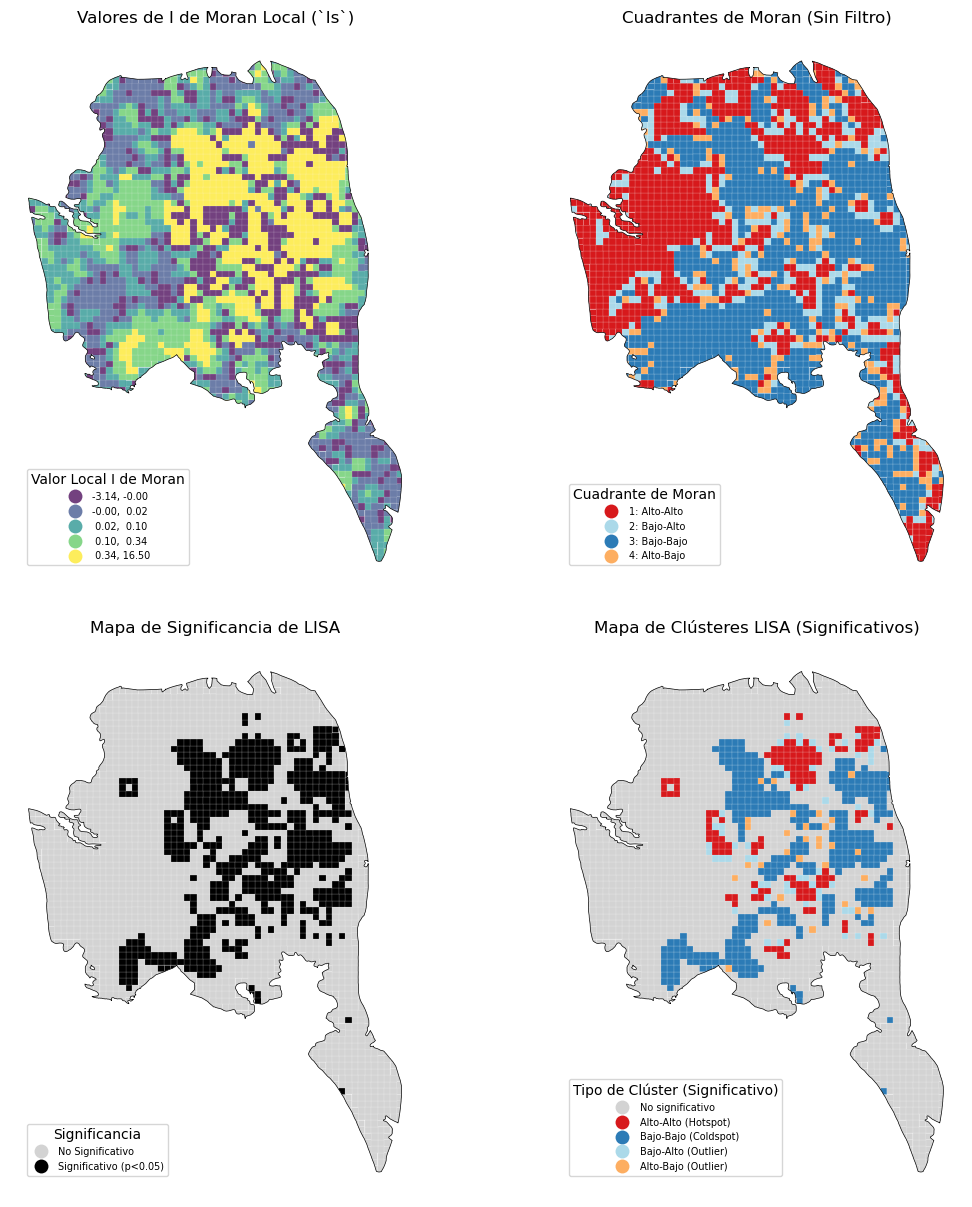

In [10]:
# Autocorrelación espacial local

import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import libpysal
from esda.moran import Moran_Local

os.makedirs(output_dir, exist_ok=True)

#  Matriz de pesos espaciales
w = libpysal.weights.Queen.from_dataframe(grid_model)
w.transform = 'r'

# Calcular LISA local
lisa = Moran_Local(grid_model['resid_dev'].values, w)

# Guardar resultados en columnas de grid_model
grid_model['lisa_Is']    = lisa.Is
grid_model['lisa_p_sim'] = lisa.p_sim
grid_model['lisa_q']     = lisa.q

# Definir clusters significativos
sig = lisa.p_sim < 0.05
grid_model['lisa_significant_cluster'] = 'No significativo'
grid_model.loc[sig & (lisa.q==1), 'lisa_significant_cluster'] = 'Alto-Alto (Hotspot)'
grid_model.loc[sig & (lisa.q==2), 'lisa_significant_cluster'] = 'Bajo-Alto (Outlier)'
grid_model.loc[sig & (lisa.q==3), 'lisa_significant_cluster'] = 'Bajo-Bajo (Coldspot)'
grid_model.loc[sig & (lisa.q==4), 'lisa_significant_cluster'] = 'Alto-Bajo (Outlier)'

# Panel de 4 mapas LISA
fig, axs = plt.subplots(2, 2, figsize=(12,12))
axs = axs.flatten()
TITLE_Y_POS   = 1.01
LEGEND_LOC    = 'lower left'
LEGEND_BBOX   = (0.03,0.03)
LEGEND_FSIZE  = 7

# Mapa 1: Valores locales I de Moran
grid_model.plot(
    column='lisa_Is', cmap='viridis', scheme='quantiles', k=5,
    edgecolor='white', linewidth=0.1, alpha=0.75,
    legend=True,
    legend_kwds={
      'title': "Valor Local I de Moran",
      'loc': LEGEND_LOC,
      'bbox_to_anchor': LEGEND_BBOX,
      'prop': {'size': LEGEND_FSIZE}
    },
    ax=axs[0]
)
gdf_contour.boundary.plot(ax=axs[0], edgecolor='black', linewidth=0.5)
axs[0].set_title("Valores de I de Moran Local (`Is`)", y=TITLE_Y_POS)
axs[0].set_axis_off()

# Mapa 2: Cuadrantes de Moran (sin filtro)
q_labels = ['1: Alto-Alto','2: Bajo-Alto','3: Bajo-Bajo','4: Alto-Bajo']
labels   = [q_labels[i-1] for i in grid_model['lisa_q']]
cmap_q   = ListedColormap(['#d7191c','#abd9e9','#2c7bb6','#fdae61'])
grid_model.assign(cl=labels).plot(
    column='cl', categorical=True, cmap=cmap_q, edgecolor='white', linewidth=0.1,
    legend=True,
    legend_kwds={
      'title':"Cuadrante de Moran",
      'loc':LEGEND_LOC,
      'bbox_to_anchor':LEGEND_BBOX,
      'prop':{'size':LEGEND_FSIZE}
    },
    ax=axs[1]
)
gdf_contour.boundary.plot(ax=axs[1], edgecolor='black', linewidth=0.5)
axs[1].set_title("Cuadrantes de Moran (Sin Filtro)", y=TITLE_Y_POS)
axs[1].set_axis_off()

# Mapa 3: Significancia
sig_labels = ['No Significativo','Significativo (p<0.05)']
sig_cat    = (grid_model['lisa_p_sim'] < 0.05).astype(int)
cmap_sig   = ListedColormap(['lightgrey','black'])
grid_model.assign(cl=[sig_labels[i] for i in sig_cat]).plot(
    column='cl', categorical=True, cmap=cmap_sig, edgecolor='white', linewidth=0.1,
    legend=True,
    legend_kwds={
      'title':"Significancia",
      'loc':LEGEND_LOC,
      'bbox_to_anchor':LEGEND_BBOX,
      'prop':{'size':LEGEND_FSIZE}
    },
    ax=axs[2]
)
gdf_contour.boundary.plot(ax=axs[2], edgecolor='black', linewidth=0.5)
axs[2].set_title("Mapa de Significancia de LISA", y=TITLE_Y_POS)
axs[2].set_axis_off()

# Mapa 4: Clusters significativos
order = ['No significativo','Alto-Alto (Hotspot)','Bajo-Bajo (Coldspot)',
         'Bajo-Alto (Outlier)','Alto-Bajo (Outlier)']
cats  = [c for c in order if c in grid_model['lisa_significant_cluster'].unique()]
grid_model['lisa_significant_cluster'] = pd.Categorical(
    grid_model['lisa_significant_cluster'], categories=cats, ordered=True
)
colors = {
  'No significativo':'lightgrey',
  'Alto-Alto (Hotspot)':'#d7191c',
  'Bajo-Bajo (Coldspot)':'#2c7bb6',
  'Bajo-Alto (Outlier)':'#abd9e9',
  'Alto-Bajo (Outlier)':'#fdae61'
}
cmap_cl = ListedColormap([colors[c] for c in cats])
grid_model.plot(
    column='lisa_significant_cluster', categorical=True, cmap=cmap_cl,
    edgecolor='white', linewidth=0.1, legend=True,
    legend_kwds={
      'title':"Tipo de Clúster (Significativo)",
      'loc':LEGEND_LOC,
      'bbox_to_anchor':LEGEND_BBOX,
      'prop':{'size':LEGEND_FSIZE}
    },
    ax=axs[3]
)
gdf_contour.boundary.plot(ax=axs[3], edgecolor='black', linewidth=0.5)
axs[3].set_title("Mapa de Clústeres LISA (Significativos)", y=TITLE_Y_POS)
axs[3].set_axis_off()


fig.tight_layout(pad=0.5, h_pad=2.5)
out_path = os.path.join(output_dir, 'panel_desglose_LISA_final.png')
fig.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()


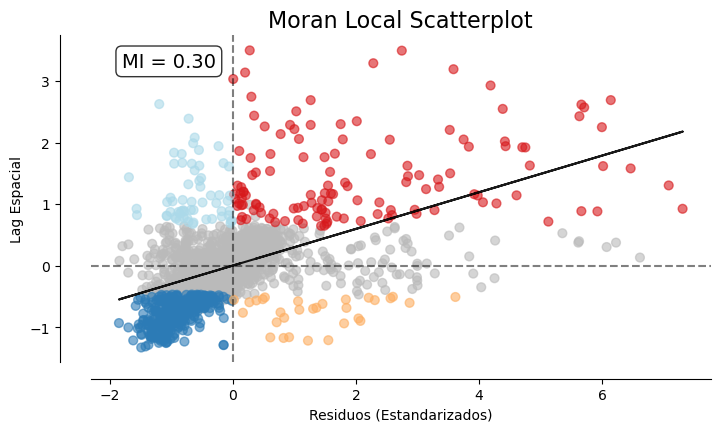

In [11]:
# Gráfico de Moran local

from splot.esda import moran_scatterplot
import matplotlib.pyplot as plt
import os

# Creamos la figura y el eje
fig, ax = plt.subplots(figsize=(8, 8))

# Usamos la función de splot para generar el gráfico
moran_scatterplot(lisa, p=0.05, ax=ax)

# Anotación figura

ax.text(0.05, 0.95, f'MI = {moran_global.I:.2f}', 
        transform=ax.transAxes, ha='left', va='top', fontsize=14,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

#  Títulos ejes
ax.set_xlabel("Residuos (Estandarizados)")
ax.set_ylabel("Lag Espacial")
ax.set_title('Moran Local Scatterplot', fontsize=16)

output_path_moran_final = os.path.join(output_dir, 'grafico_moran_final.png')
plt.savefig(output_path_moran_final, dpi=300, bbox_inches='tight')
plt.show()

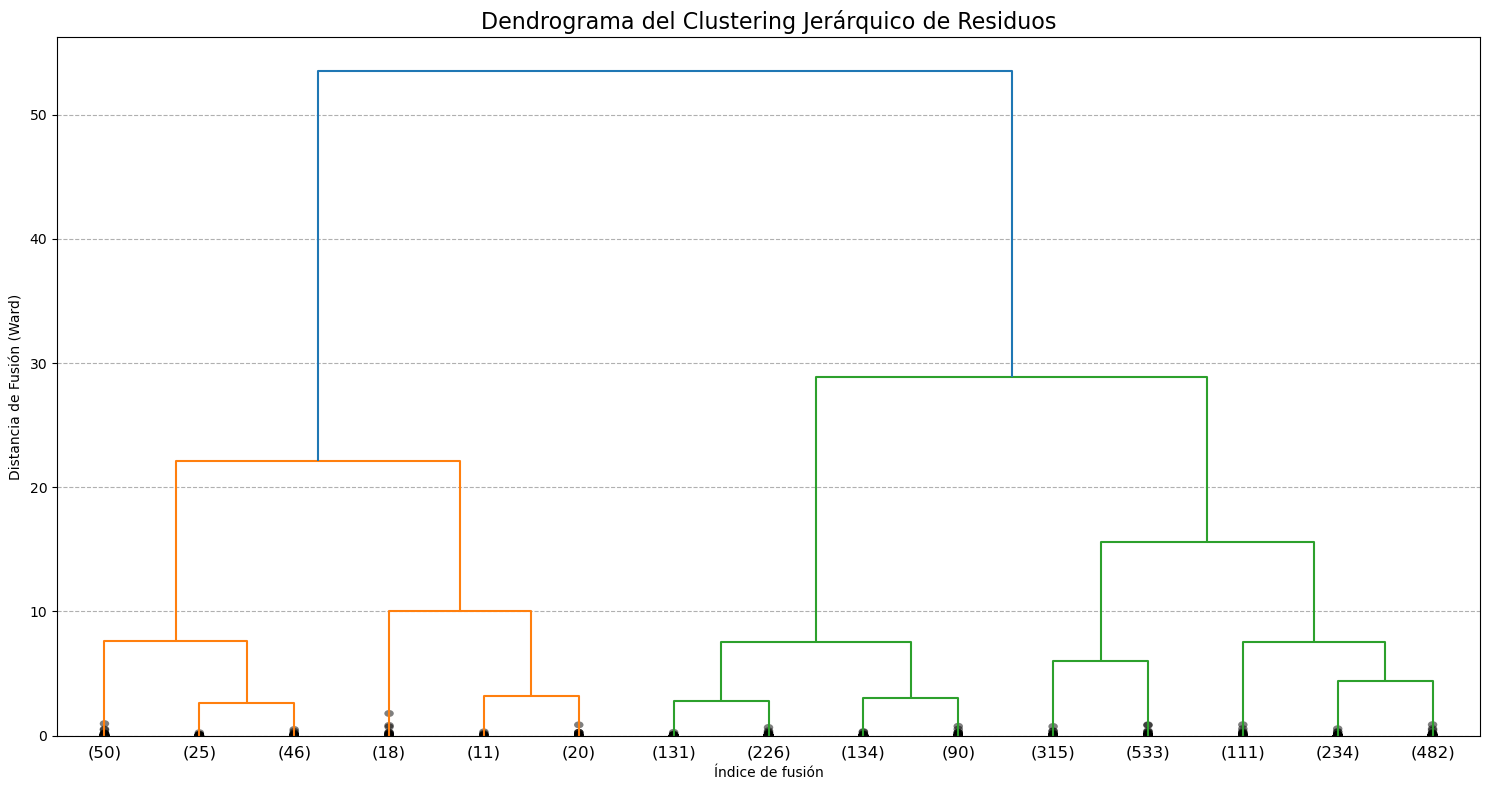

In [12]:
# Agrupamiento espacial: Dendrograma de residuos

import os
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Estandarizar residuos 
scaler = StandardScaler()
data_to_cluster = scaler.fit_transform(grid_model[['resid_dev']])

# Calcular la matriz de linkage (método Ward)
linked = linkage(data_to_cluster, method='ward', metric='euclidean')

# Graficar el dendrograma
plt.figure(figsize=(15, 8))
dendrogram(
    linked,
    orientation='top',
    truncate_mode='lastp',  # mostrar solo las últimas p fusiones
    p=15,                   # ajusta este valor según detalle deseado
    show_leaf_counts=True,
    show_contracted=True,
)
plt.title('Dendrograma del Clustering Jerárquico de Residuos', fontsize=16)
plt.xlabel('Índice de fusión')
plt.ylabel('Distancia de Fusión (Ward)')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()


os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'dendrograma_residuos.png'), dpi=300, bbox_inches='tight')

plt.show()


C:\Users\esteb\AppData\Local\Temp\ipykernel_27036\3673842322.py:12: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_original = libpysal.weights.Queen.from_dataframe(grid_model)


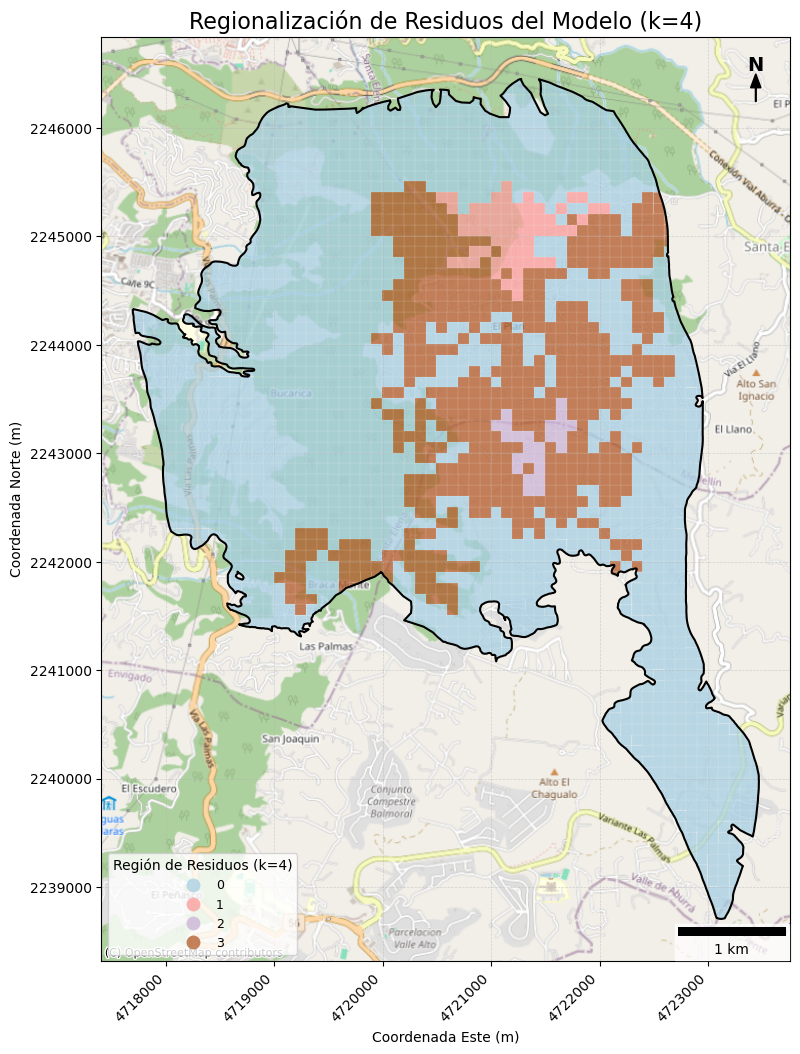

In [21]:
# Agrupamiento espacial (Regionalización) k=4

import os
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import libpysal

# Matriz (Queen)
w_original = libpysal.weights.Queen.from_dataframe(grid_model)
w_original.transform = 'r'

# Estandarizar residuos
scaler = StandardScaler()
X_std = scaler.fit_transform(grid_model[['resid_dev']])

# Ajustar clustering jerárquico aglomerativo con k=4
agg = AgglomerativeClustering(
    n_clusters=4,
    linkage='ward',
    connectivity=w_original.sparse
)
labels = agg.fit_predict(X_std)

# Asignar etiquetas al GeoDataFrame
grid_model['region_k4'] = labels.astype(int)

# Crear la figura y el mapa
fig, ax = plt.subplots(figsize=(12, 12))

grid_model.plot(
    column='region_k4',
    categorical=True,
    legend=True,
    ax=ax,
    cmap='Paired',
    edgecolor='white',
    linewidth=0.1,
    alpha=0.75,
    legend_kwds={
        'title': "Región de Residuos (k=4)",
        'loc': 'lower left',
        'prop': {'size': 9},
        'frameon': True,
        'facecolor': 'white',
        'framealpha': 0.8
    }
)

# Contorno, basemap y elementos cartográficos
gdf_contour.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)
cx.add_basemap(ax, crs=grid_model.crs.to_string(),
               source=cx.providers.OpenStreetMap.Mapnik, zoom='auto')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax.set_xlabel("Coordenada Este (m)")
ax.set_ylabel("Coordenada Norte (m)")
ax.ticklabel_format(style='plain', useOffset=False)
plt.xticks(rotation=45, ha='right')

ax.add_artist(ScaleBar(dx=1, units="m", location="lower right",
                      frameon=True, color='black', box_alpha=0.7))

x_n, y_n = 0.95, 0.97
ax.text(x_n, y_n, "N", transform=ax.transAxes,
        ha="center", va="center",
        fontsize=14, fontweight="bold", zorder=5)
ax.arrow(x_n, y_n - 0.04, 0, 0.03, transform=ax.transAxes,
         head_width=0.015, head_length=0.015,
         fc='black', ec='black',
         length_includes_head=True, zorder=5)

ax.set_title("Regionalización de Residuos del Modelo (k=4)", fontsize=16)


os.makedirs(output_dir, exist_ok=True)
out_file = os.path.join(output_dir, 'mapa_regiones_residuos_k4_final.png')
plt.savefig(out_file, dpi=300, bbox_inches='tight')
plt.show()

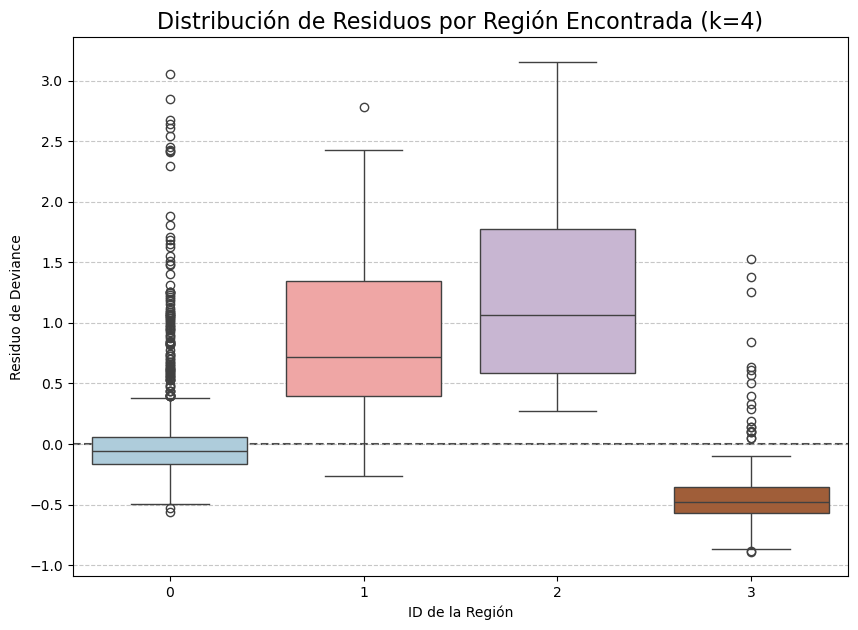

            count      mean       std       min       25%       50%       75%  \
region_k4                                                                       
0          1781.0 -0.006049  0.344926 -0.558923 -0.168373 -0.055160  0.053564   
1            63.0  0.890907  0.700055 -0.266143  0.392689  0.716794  1.347186   
2            25.0  1.206263  0.794773  0.270881  0.584569  1.067583  1.777205   
3           557.0 -0.445134  0.237450 -0.889291 -0.566226 -0.475254 -0.359038   

                max  
region_k4            
0          3.055460  
1          2.782390  
2          3.155080  
3          1.524878  


In [22]:
# Diagrama de cajas y bigotes

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Se Crea la paleta de colores para que coincida con el mapa anterior

color_palette = {
    '0': '#a6cee3', # Un azul claro exacto
    '1': '#fb9a99', # Un rojo/rosa claro exacto
    '2': '#cab2d6', # Un púrpura claro exacto
    '3': '#b15928'  # Un marrón/naranja oscuro exacto
}

# Preparación datos

grid_model['region_k4_str'] = grid_model['region_k4'].astype(str)
plot_order = [str(i) for i in sorted(grid_model['region_k4'].unique())]


# Figura
fig, ax = plt.subplots(figsize=(10, 7))

sns.boxplot(
    x='region_k4_str', 
    y='resid_dev', 
    hue='region_k4_str',
    data=grid_model, 
    ax=ax, 
    palette=color_palette, 
    order=plot_order,
    legend=False
)

# Línea de referencia en cero y damos formato
ax.axhline(0, color='black', linestyle='--', alpha=0.7, zorder=0)
ax.set_title('Distribución de Residuos por Región Encontrada (k=4)', fontsize=16)
ax.set_xlabel('ID de la Región')
ax.set_ylabel('Residuo de Deviance')
ax.grid(axis='y', linestyle='--', alpha=0.7)


output_path_boxplot_final = os.path.join(output_dir, 'boxplot_regiones_k4_colores_finales.png')
plt.savefig(output_path_boxplot_final, dpi=300, bbox_inches='tight')
plt.show()

# Resumen numérico
print(grid_model.groupby('region_k4')['resid_dev'].describe())